### ISSUES and TODOs

- see `README.md`

1) use one-sided spectrum

2) sometimes FD after augmentation is just a flat line. Why?

3) is it VALID to zero out frequency coefficients for augmentation?

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os, argparse, json, copy, wandb

from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.fft as fft

import pandas as pd
import numpy as np
from termcolor import cprint
from pprint import pprint
from tqdm import tqdm
from datetime import datetime

from train import finetune

from trainer import Trainer, model_finetune, model_test, model_pretrain
from train import evaluate

from augmentations import *
from dataloader import MIdatasetMC
from config_files.BIG_EEG_MI_1chRearrange import Config as Configs
from utils import _logger, set_requires_grad
from model import *
from utils import _calc_metrics, copy_Files
from loss import * # base_Model, base_Model_F, target_classifier


# For Arial
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams["text.usetex"] = False

# for latex:
# matplotlib.rcParams['font.family'] = "DejaVu Sans"
# matplotlib.rcParams['font.serif'] = "Computer Modern"
# matplotlib.rcParams["text.usetex"] = True

matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["axes.labelsize"] = 22
matplotlib.rcParams["xtick.labelsize"] = 22
matplotlib.rcParams["ytick.labelsize"] = 22
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams["legend.fontsize"] = 22
matplotlib.rcParams["axes.titlesize"] = 22
matplotlib.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["figure.autolayout"] = True

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'

print(f'CUDA available: {torch.cuda.is_available()}')
cprint(torch.__version__, color='green')
device_count = torch.cuda.device_count()
for i in range(device_count):
    torch.cuda.set_device(i)
    cur_device_id = torch.cuda.current_device()
    cur_device_name = torch.cuda.get_device_name(cur_device_id)
    print(f'Current device:\nID {cur_device_id} | Name: {cur_device_name}')
    print(f'supported arch list: {torch.cuda.get_arch_list()}\n')
    

CUDA available: True
1.12.1+cu113
Current device:
ID 0 | Name: RTX A6000
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Current device:
ID 1 | Name: Quadro P2200
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']



In [3]:
training_mode = 'pre_train'   # 'fine_tune_test'
device = 'cuda:0'
configs = Configs()
configs.report()


{'CNNoutput_channel': 10,
 'Context_Cont': <config_files.BIG_EEG_MI_1chRearrange.Context_Cont_configs object at 0x7eff78335670>,
 'TC': <config_files.BIG_EEG_MI_1chRearrange.TC object at 0x7eff78335310>,
 'TSlength_aligned': 150,
 'augmentation': <config_files.BIG_EEG_MI_1chRearrange.augmentations object at 0x7eff78335dc0>,
 'batch_size': 96,
 'beta1': 0.9,
 'beta2': 0.99,
 'drop_last': True,
 'dropout': 0.35,
 'final_out_channels': 20,
 'increased_dim': 1,
 'input_channels': 1,
 'kernel_size': 25,
 'lr': 0.0003,
 'lr_f': 0.0003,
 'num_classes': 2,
 'num_classes_target': 2,
 'num_epoch': 40,
 'optimizer': 'adam',
 'report': <bound method Config.report of <config_files.BIG_EEG_MI_1chRearrange.Config object at 0x7eff78335910>>,
 'stride': 3,
 'target_batch_size': 96,
 'z_dim': 16}

{'boostFreqBy': 0.1,
 'max_seg': 12,
 'noise_std': 0.3,
 'pertubFreqRatio': 0.1,
 'remove_how_much': 0.1,
 'scaling_mean': 2.0,
 'scaling_sigma': 0.1,
 'superposition': False}


In [4]:
# load the data and instantiate the Dataset class

path = '/home/roman/CODE/tachikoma-analysis/DATA'

# load the torch tensor
dataset = torch.load(os.path.join(path, "BIG_MI_11_datasets_36089samp.pt"))
dataset['info']

"Srate = 100 Hz, passband: 0-45 Hz, channels ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']. See meta for more details. See /home/roman/CODE/tachikoma-analysis/DATA"

<AxesSubplot:ylabel='ds'>

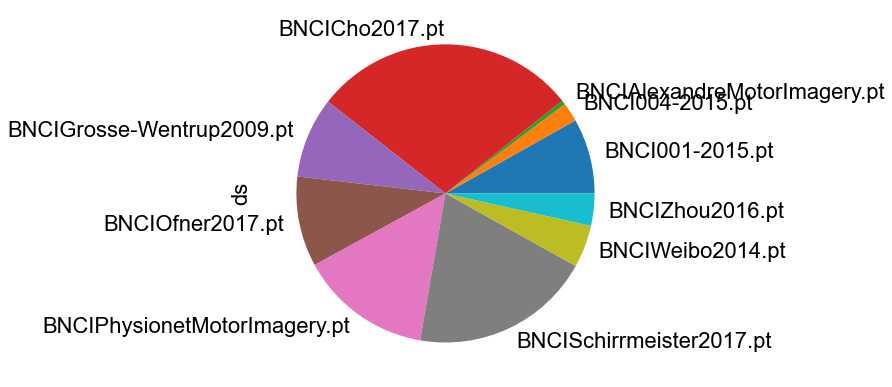

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
dataset['meta'].groupby('ds').ds.count().plot.pie(ax=ax)

In [6]:
# set aside one dataset for finetuning, the rest are for pre-training and testing

pretrain_idx = np.where(dataset['meta'].ds != 'BNCIPhysionetMotorImagery.pt')[0]
finetune_idx_ = np.where(dataset['meta'].ds == 'BNCIPhysionetMotorImagery.pt')[0]

pretrain_dataset = dict()
finetune_dataset_ = dict()
finetune_dataset = dict()
test_dataset = dict()


pretrain_dataset['samples'] = copy.deepcopy(dataset['samples'][pretrain_idx, :, :])
pretrain_dataset['labels'] = copy.deepcopy(dataset['labels'][pretrain_idx])
pretrain_dataset['meta'] = copy.deepcopy(dataset['meta'].iloc[pretrain_idx].reset_index(drop=True))

finetune_dataset_['samples'] = copy.deepcopy(dataset['samples'][finetune_idx_, :, :])
finetune_dataset_['labels'] = copy.deepcopy(dataset['labels'][finetune_idx_])
finetune_dataset_['meta'] = copy.deepcopy(dataset['meta'].iloc[finetune_idx_].reset_index(drop=True))


finetune_idx, test_idx = train_test_split(list(range(finetune_dataset_['meta'].shape[0])), test_size=0.2)

finetune_dataset['samples'] = copy.deepcopy(finetune_dataset_['samples'][finetune_idx, :, :])
finetune_dataset['labels'] = copy.deepcopy(finetune_dataset_['labels'][finetune_idx])
finetune_dataset['meta'] = copy.deepcopy(finetune_dataset_['meta'].iloc[finetune_idx].reset_index(drop=True))

test_dataset['samples'] = copy.deepcopy(finetune_dataset_['samples'][test_idx, :, :])
test_dataset['labels'] = copy.deepcopy(finetune_dataset_['labels'][test_idx])
test_dataset['meta'] = copy.deepcopy(finetune_dataset_['meta'].iloc[test_idx].reset_index(drop=True))

del finetune_dataset_
del dataset

In [7]:
pretrain_dataset['samples'].shape, finetune_dataset['samples'].shape, test_dataset['samples'].shape

(torch.Size([29431, 7, 150]),
 torch.Size([3934, 7, 150]),
 torch.Size([984, 7, 150]))

In [8]:
pretrain_dataset['meta']

,subject,session,run,label,labs,ds
0,1,imagination,run_0,right_pronation,0,BNCIOfner2017.pt
1,1,imagination,run_0,right_hand_close,0,BNCIOfner2017.pt
2,1,imagination,run_0,right_hand_open,0,BNCIOfner2017.pt
3,1,imagination,run_0,right_supination,0,BNCIOfner2017.pt
4,1,imagination,run_0,right_hand_open,0,BNCIOfner2017.pt
...,...,...,...,...,...,...
29426,8,session_0,run_0,right_hand,0,BNCIAlexandreMotorImagery.pt
29427,8,session_0,run_0,right_hand,0,BNCIAlexandreMotorImagery.pt
29428,8,session_0,run_0,right_hand,0,BNCIAlexandreMotorImagery.pt
29429,8,session_0,run_0,right_hand,0,BNCIAlexandreMotorImagery.pt


In [9]:
finetune_dataset['meta']

,subject,session,run,label,labs,ds
0,104,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
1,95,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
2,78,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
3,28,session_0,run_2,right_hand,0,BNCIPhysionetMotorImagery.pt
4,85,session_0,run_1,left_hand,1,BNCIPhysionetMotorImagery.pt
...,...,...,...,...,...,...
3929,13,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
3930,55,session_0,run_0,right_hand,0,BNCIPhysionetMotorImagery.pt
3931,72,session_0,run_2,right_hand,0,BNCIPhysionetMotorImagery.pt
3932,8,session_0,run_0,right_hand,0,BNCIPhysionetMotorImagery.pt


In [10]:
test_dataset['meta']

,subject,session,run,label,labs,ds
0,73,session_0,run_0,right_hand,0,BNCIPhysionetMotorImagery.pt
1,4,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
2,17,session_0,run_1,left_hand,1,BNCIPhysionetMotorImagery.pt
3,88,session_0,run_2,right_hand,0,BNCIPhysionetMotorImagery.pt
4,32,session_0,run_0,left_hand,1,BNCIPhysionetMotorImagery.pt
...,...,...,...,...,...,...
979,103,session_0,run_2,right_hand,0,BNCIPhysionetMotorImagery.pt
980,88,session_0,run_0,left_hand,1,BNCIPhysionetMotorImagery.pt
981,106,session_0,run_2,right_hand,0,BNCIPhysionetMotorImagery.pt
982,2,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt


In [11]:
# seed everything
SEED = 0
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [15]:
# instantiate the Dataset class
ds = MIdatasetMC(pretrain_dataset, configs)

torch.Size([29431, 7, 150])


Text(0.5, 0.98, 'Sample ID: 12002')

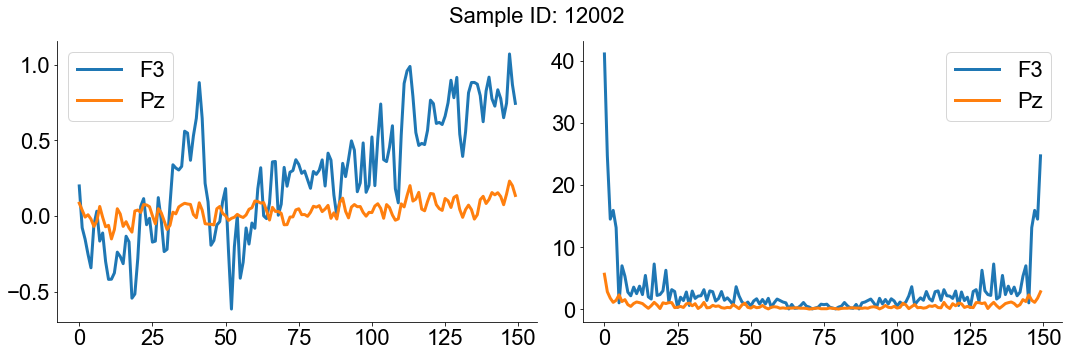

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))

sampid = np.random.choice(len(ds))
sampid = 12002

choi = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']


x,_,_,_,_,_,_,_ = ds[sampid]
x_f = fft.fft(x).abs()

ax0.plot(x[choi.index('F3'),:].squeeze().numpy(), label=f'{choi[0]}')
ax0.plot(x[choi.index('F4'),:].squeeze().numpy(), label=f'{choi[-1]}')
ax0.legend()

ax1.plot(x_f[choi.index('F3'),:].squeeze().numpy(), label=f'{choi[0]}')
ax1.plot(x_f[choi.index('F4'),:].squeeze().numpy(), label=f'{choi[-1]}')
ax1.legend()

plt.suptitle(f'Sample ID: {sampid}', fontsize=22)

In [16]:
# metadata per each data point (for debugging)

finetune_dataset['meta']

,subject,session,run,label,labs,ds
0,23,session_0,run_2,right_hand,0,BNCIPhysionetMotorImagery.pt
1,63,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
2,31,session_0,run_0,right_hand,0,BNCIPhysionetMotorImagery.pt
3,83,session_0,run_2,right_hand,0,BNCIPhysionetMotorImagery.pt
4,106,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
...,...,...,...,...,...,...
3929,49,session_0,run_0,left_hand,1,BNCIPhysionetMotorImagery.pt
3930,33,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
3931,15,session_0,run_1,left_hand,1,BNCIPhysionetMotorImagery.pt
3932,88,session_0,run_1,left_hand,1,BNCIPhysionetMotorImagery.pt


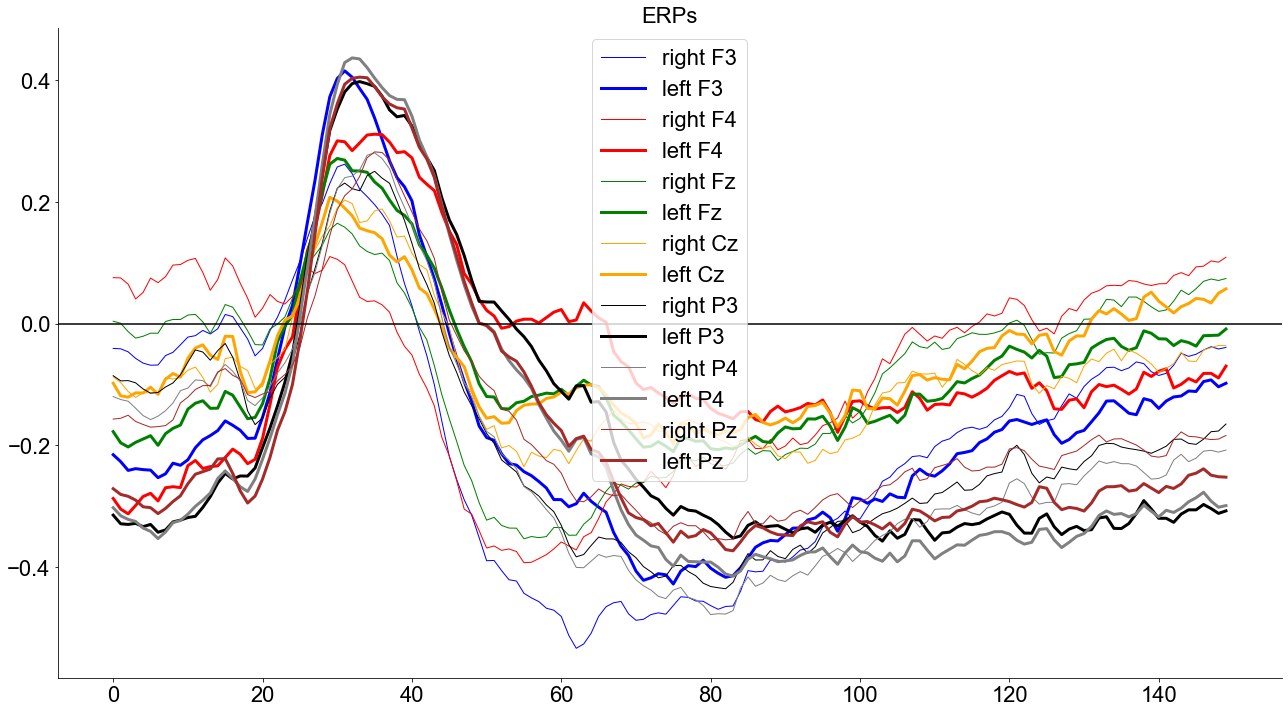

In [17]:
c = ['blue', 'red', 'green', 'orange', 'black', 'grey', 'brown']

plt.figure(figsize=(18, 10))

rights = np.where(finetune_dataset['meta'].labs == 0)[0]
lefts =  np.where(finetune_dataset['meta'].labs == 1)[0]

for i in range(7):
    plt.plot(finetune_dataset['samples'][rights, i,: ].mean(axis=0).squeeze(), color=c[i], lw=1, label=f'right {choi[i]}')
    plt.plot(finetune_dataset['samples'][lefts,  i,: ].mean(axis=0).squeeze(), color=c[i], lw=3, label=f'left {choi[i]}')
    
plt.legend()
plt.axhline(0, color='k', lw=1.5)

_ = plt.title('ERPs')

In [18]:
# get one data point (not batch)

x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta = ds[1000]
meta, y

({'subject': 5,
  'session': 'imagination',
  'run': 'run_1',
  'label': 'right_supination',
  'labs': 0,
  'ds': 'BNCIOfner2017.pt'},
 tensor(0))

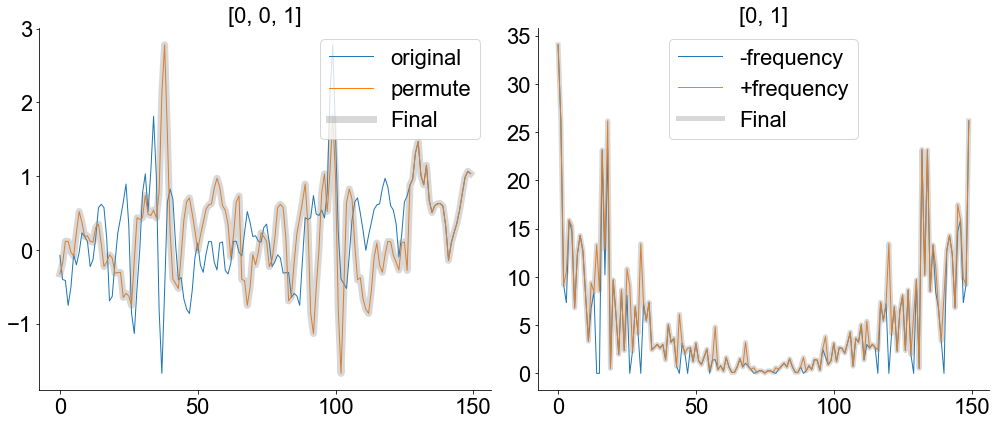

In [19]:
# validate augmentations (debugging)

ch = 4

x_t, _, _, x_f, _, _, _,_ = ds[2]
aug_T, aug_1_t, aug_2_t, aug_3_t, msk_t = DataTransform_TD(x_t, configs)
aug_F, aug_1_f, aug_2_f, msk_f = DataTransform_FD(x_f, configs)

n = np.random.choice(x_t.shape[0])


fig, (ax, ax1) = plt.subplots(1,2,figsize=(14,6))

if len(x_t.shape) == 2:
    ax.plot(x_t[ch,:].detach().numpy(), lw=1, label='original')
    if np.argmax(msk_t.tolist()) == 0:
        ax.plot(aug_1_t[ch,:].detach().numpy(), lw=1, label='jitter')
    elif np.argmax(msk_t.tolist()) == 1:
        ax.plot(aug_2_t[ch,:].detach().numpy(), lw=1, label='scale')
    elif np.argmax(msk_t.tolist()) == 2:
        ax.plot(aug_3_t[ch,:].detach().numpy(), lw=1, label='permute')
    else:
        raise
    ax.plot(aug_T[ch,:].detach().numpy(), lw=7, alpha=0.3, color='grey', label='Final')
    ax.set_title(msk_t.tolist())
    ax.legend()


    ax1.plot(aug_1_f[ch,:].detach().numpy(), lw=1, label='-frequency')
    ax1.plot(aug_2_f[ch,:].detach().numpy(), lw=1, label='+frequency')
    ax1.plot(aug_F[ch,:].detach().numpy(), lw=5, alpha=0.3, color='grey', label='Final')
    ax1.set_title(msk_f.tolist())
    ax1.legend()
    # ax1.set_ylim(0, 20)
    # ax1.set_xlim(150, 250)
    
if len(x_t.shape) == 3:
    ax.plot(x_t[n, ch,:].detach().numpy(), lw=1, label='original')
    ax.plot(aug_1_t[n, ch,:].detach().numpy(), lw=1, label='jitter')
    ax.plot(aug_2_t[n, ch,:].detach().numpy(), lw=1, label='scale')
    ax.plot(aug_3_t[n, ch,:].detach().numpy(), lw=1, label='permute')
    ax.plot(aug_T[n, ch,:].detach().numpy(), lw=7, alpha=0.3, color='grey', label='Final')
    ax.set_title(msk_t[n,:].tolist())
    ax.legend()


    ax1.plot(aug_1_f[n, ch,:].detach().numpy(), lw=1, label='-frequency')
    ax1.plot(aug_2_f[n, ch,:].detach().numpy(), lw=1, label='+frequency')
    ax1.plot(aug_F[n, ch,:].detach().numpy(), lw=5, alpha=0.3, color='grey', label='Final')
    ax1.set_title(msk_f[n,:].tolist())
    ax1.legend()
    # ax1.set_ylim(0, 20)
#     ax1.set_xlim(150, 250)


In [20]:
# create a dataloader with the optimal number of workers

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

train_dl = torch.utils.data.DataLoader(
    dataset=ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=14) # optimal: 14 workers with batch_size=60

In [21]:
# %%time
for x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta in tqdm(train_dl, bar_format=bar_format):
    pass

x_t.shape, y.shape, x_t_aug.shape

100%|██████████| 613/613 [00:03<00:00, 196.15it/s]                                                                                                            


(torch.Size([48, 7, 150]), torch.Size([48]), torch.Size([48, 7, 150]))

In [22]:
# for debugging, inspect where each data point comes from

pd.DataFrame(meta).head(10)

,subject,session,run,label,labs,ds
0,6,session_0,train,left_hand,1,BNCISchirrmeister2017.pt
1,1,session_1,run_1,right_hand,0,BNCIZhou2016.pt
2,10,session_0,train,right_hand,0,BNCISchirrmeister2017.pt
3,10,session_0,run_0,left_hand,1,BNCICho2017.pt
4,15,session_0,run_0,right_hand,0,BNCICho2017.pt
5,48,session_0,run_0,left_hand,1,BNCICho2017.pt
6,13,session_0,train,right_hand,0,BNCISchirrmeister2017.pt
7,26,session_0,run_0,left_hand,1,BNCICho2017.pt
8,12,session_0,train,right_hand,0,BNCISchirrmeister2017.pt
9,14,session_0,train,right_hand,0,BNCISchirrmeister2017.pt


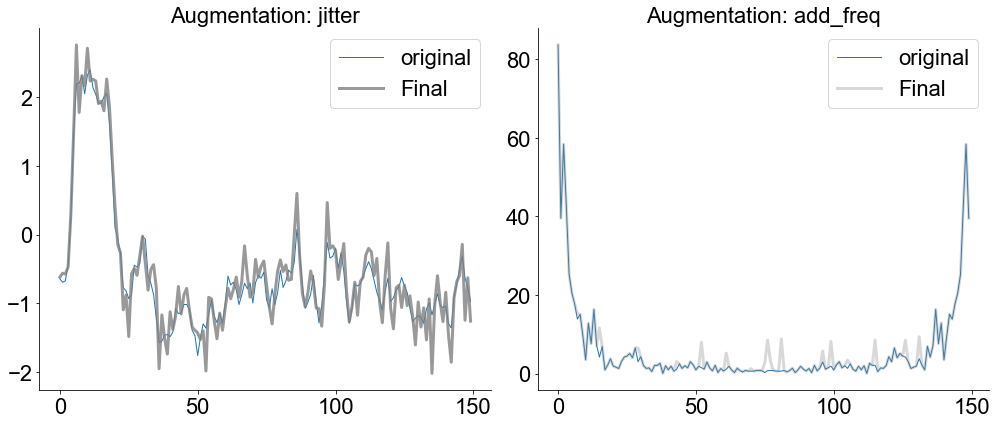

In [23]:
# inspect data augmented points

n = 13
ch = 0

TDaugNames = ['jitter', 'scale', 'permute']
FDaugNames = ['rm_freq', 'add_freq']

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(14,6))

ax.plot(x_t[n, ch,:].detach().numpy(), lw=1, label='original')
ax.plot(x_t_aug[n, ch,:].detach().numpy(), lw=3, alpha=0.8, color='grey', label='Final')
ax.set_title(f'Augmentation: {TDaugNames[np.argmax(msk_t[n].tolist())]}')
ax.legend()
ax1.plot(x_f[n, ch,:].detach().numpy(), lw=1, label='original')
ax1.plot(x_f_aug[n, ch,:].detach().numpy(), lw=3, alpha=0.3, color='grey', label='Final')
ax1.set_title(f'Augmentation: {FDaugNames[np.argmax(msk_f[n].tolist())]}')
ax1.legend()
# ax1.set_ylim(0, 20)
# ax1.set_xlim(150, 250)

In [12]:
# Build TFC feature detector and classifier

TFC_model = TFCmultiToOne(configs).to(device)
classifier = ClassifierMultiToOne(
    configs,
    num_chans=finetune_dataset['samples'].shape[1]).to(device)

cprint(TFC_model, color='grey')

cprint(classifier, color='red')

number of parameters in model: 66800
number of parameters in model: 12714
TFCmultiToOne(
  (conv_block1_t): Sequential(
    (0): Conv1d(1, 32, kernel_size=(25,), stride=(3,), padding=(12,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (conv_block2_t): Sequential(
    (0): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block3_t): Sequential(
    (0): Conv1d(64, 20, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2,

In [14]:
# load model parameters
# TFC_model.load_state_dict(torch.load('TFC_model_1chRearrange_pretrained_160ep.wts'))

In [ ]:
# pretrain:

wandb.config = configs
wandb.init(project="TFC_1ch_rearrange_pretraining", 
           entity="nightdude",
           config=wandb.config,
           save_code=False)
wandb.watch(TFC_model, log_freq=20)

# instantiate the Dataset class
pretrain_ds = MIdatasetMC(pretrain_dataset, configs)

# instantiate a dataloader for the fine-tuning dataset
pretrain_dl = torch.utils.data.DataLoader(
    dataset=pretrain_ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=14) # optimal: 14 workers with batch_size=60

TFC_model.train()
model_optimizer = torch.optim.Adam(TFC_model.parameters(),
                                   lr=configs.lr,
                                   betas=(configs.beta1, configs.beta2),
                                   weight_decay=3e-4)

nt_xent_criterion = NTXentLoss_poly(
            device,
            configs.batch_size,
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity, 
            batch_mult = pretrain_dataset['samples'].shape[1])  # needed for the reaarrange variant. Leave at default for others.

EPOCHS = 150
L, total_loss = [], []


for ep in range(0, EPOCHS):
    for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in tqdm(enumerate(pretrain_dl)):

        x_t, y = x_t.float().to(device), y.long().to(device)
        x_t_aug = x_t_aug.float().to(device)
        x_f, x_f_aug = x_f.float().to(device), x_f_aug.float().to(device)
        
        model_optimizer.zero_grad()

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = TFC_model(x_t, x_f)                 # original data
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(x_t_aug, x_f_aug) # augmented data


        
        loss_t = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
        loss_f = nt_xent_criterion(h_f, h_f_aug) # original and perturbed data should be close in FD embedding space

        # time and frequency embeddings should be similar when projected to the joint TF space
        l_TF, l_1, l_2, l_3 = (
            nt_xent_criterion(z_t, z_f),
            nt_xent_criterion(z_t, z_f_aug),
            nt_xent_criterion(z_t_aug, z_f),
            nt_xent_criterion(z_t_aug, z_f_aug))
        
        # Each of the 3 terms below optimize the model towards a smaller l_TF and relatively larger l_(1,2,3)
        loss_c = (1 + l_TF - l_1) + (1 + l_TF - l_2) + (1 + l_TF - l_3) 

        lam = 0.2
        loss = lam * (loss_t + loss_f) + (1 - lam) * loss_c

        total_loss.append(loss.item())

        performance_now = {'ep': ep,
                  'it': i,
                  'temporal contr. loss': loss_t.item(),
                  'frequency contr. loss': loss_f.item(),
                  'TF consistency loss': l_TF.item(),
                  'TFaug consistency loss': l_1.item(),
                  'TaugF consistency loss': l_2.item(),
                  'TaugFaug consistency loss': l_3.item()}
        L.append(performance_now)
#         if i % 10:
        wandb.log(performance_now)
        
        loss.backward()
        model_optimizer.step()
wandb.finish()

wandb: Currently logged in as: nightdude. Use `wandb login --relogin` to force relogin


torch.Size([29431, 7, 150])


306it [01:22,  3.71it/s]
306it [01:21,  3.77it/s]
306it [01:21,  3.77it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.79it/s]
306it [01:20,  3.79it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.79it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.79it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.79it/s]
306it [01:21,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.79it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:21,  3.77it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.79it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.78it/s]
306it [01:20,  3.79it/s]
306it [01:21,  3.78it/s]


In [15]:
# save model parameters
torch.save(TFC_model.state_dict(), 'TFC_model_1chRearrange_pretrained_160ep.wts')

Text(0.5, 0, 'batches')

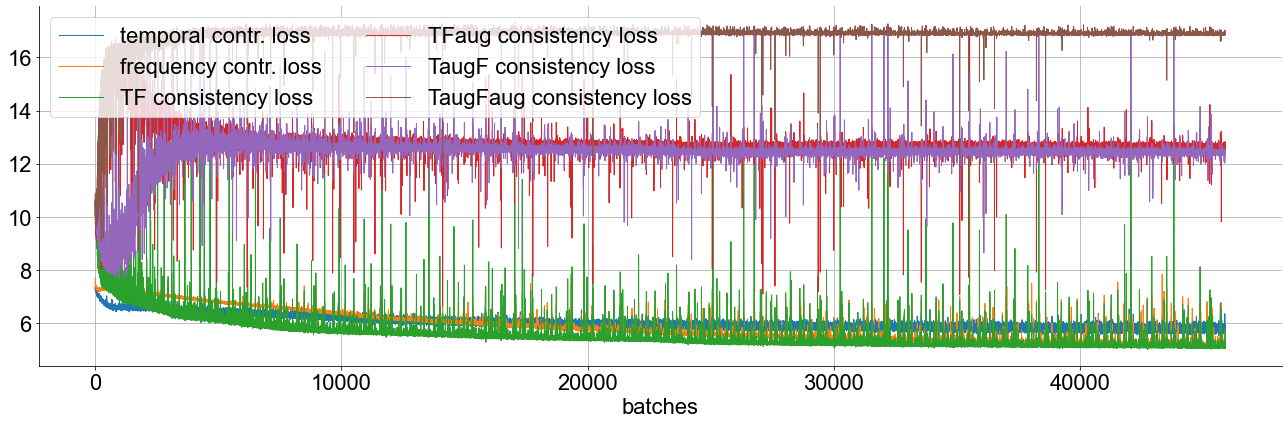

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
pd.DataFrame(L).plot(y=['temporal contr. loss',
                        'frequency contr. loss',
                        'TF consistency loss',
                        'TFaug consistency loss',
                        'TaugF consistency loss',
                        'TaugFaug consistency loss'],
                     ax=ax, lw=1,
                     legend=None)
ax.legend(ncol=2, loc='upper left')
ax.grid()
ax.set_xlabel('batches')

# now fine-tune

In [18]:
len(finetune_dataset['samples'])

3934

In [12]:

# build models from scratch
TFC_model = TFCmultiToOne(configs).to(device)

# the classifier must know how many EEG channels there are in the data
classifier = ClassifierMultiToOne(configs,
                                  num_chans=finetune_dataset['samples'].shape[1]).to(device)

# with a spatial filter over channel-specific features
# classifier = ClassifierMultiToOne_spatial(configs,
#                                           num_chans=finetune_ds[0][0].shape[0]).to(device)

# load pre-trained weights into the contrastive feature detector model, but not the classifier
TFC_model.load_state_dict(torch.load('TFC_model_1chRearrange_pretrained_160ep.wts'))

number of parameters in model: 66800
number of parameters in model: 12714


<All keys matched successfully>

In [13]:
classifier

ClassifierMultiToOne(
  (logits): Linear(in_features=224, out_features=56, bias=True)
  (logits_simple): Linear(in_features=56, out_features=2, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (SiLU): SiLU()
)

In [14]:
# finetune

epochs = 100
freeze = True

df = finetune(TFC_model, classifier, finetune_dataset, test_dataset, configs, device, epochs, freeze)

wandb: Currently logged in as: nightdude. Use `wandb login --relogin` to force relogin


torch.Size([3934, 7, 150])

Class 0 weight: 1.00

Class 1 weight: 1.00
Feature detector's parameters are frozen


L0: 0.69 w0: 0.96 L1: -15.77 w1: 0.04: : 40it [00:04,  8.45it/s]
L0: 0.69 w0: 0.96 L1: -16.34 w1: 0.04: : 40it [00:03, 12.25it/s]
40it [00:00, 55.25it/s]
40it [00:00, 55.36it/s]
40it [00:00, 57.49it/s]
40it [00:00, 55.78it/s]
40it [00:00, 56.57it/s]
40it [00:00, 57.02it/s]
40it [00:00, 52.60it/s]
40it [00:00, 51.43it/s]
40it [00:00, 58.11it/s]
40it [00:00, 56.68it/s]
40it [00:00, 56.10it/s]
40it [00:00, 59.55it/s]
40it [00:00, 54.84it/s]
40it [00:00, 54.94it/s]
40it [00:00, 53.58it/s]
40it [00:00, 55.42it/s]
40it [00:00, 55.92it/s]
40it [00:00, 63.66it/s]
40it [00:00, 55.31it/s]
40it [00:00, 56.07it/s]
40it [00:00, 58.80it/s]
40it [00:00, 55.04it/s]
40it [00:00, 58.79it/s]
40it [00:00, 56.99it/s]
40it [00:00, 55.07it/s]
40it [00:00, 56.67it/s]
40it [00:00, 59.65it/s]
40it [00:00, 56.59it/s]
40it [00:00, 58.36it/s]
40it [00:00, 59.32it/s]
40it [00:00, 55.11it/s]
40it [00:00, 58.75it/s]
40it [00:00, 61.46it/s]
40it [00:00, 59.29it/s]
40it [00:00, 57.63it/s]
40it [00:00, 55.06it/s]
40it [

Feature detector's parameters are unfrozen


In [23]:
# dat = pd.DataFrame(dat)
df.columns

Index(['ep', 'temporal contrastive loss', 'frequency contrastive loss',
       'time-frequency (t-f) consistency',
       'time - aug. freq (t-~f) consistency',
       'aug.time - freq (~t-f) consistency',
       'aug.time - aug. freq (~t-~f) consistency', 'classifier loss',
       'total_loss', 'classifier accuracy', 'AUC', 'PRC', 'recall',
       'precision', 'F1-score', 'test_acc'],
      dtype='object')

<AxesSubplot:>

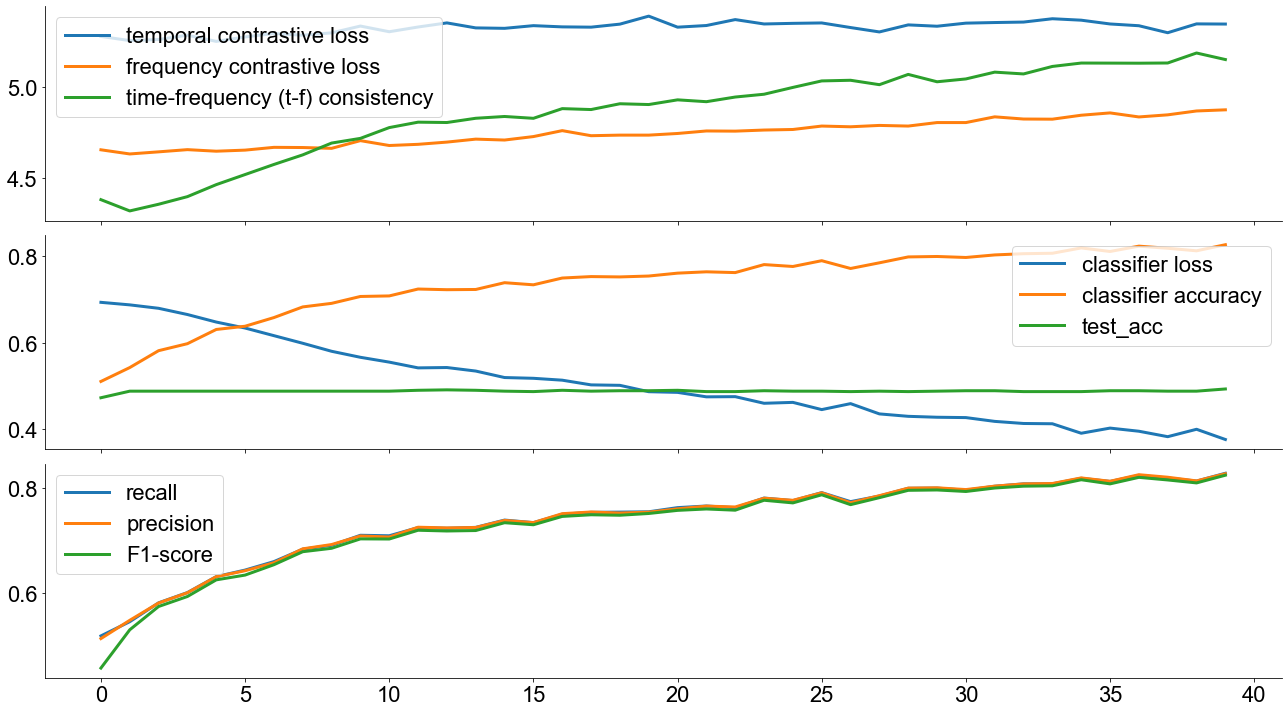

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
df.plot(y=['temporal contrastive loss',
            'frequency contrastive loss',
            'time-frequency (t-f) consistency'], ax=ax[0])

df.plot(y=['classifier loss', 'classifier accuracy', 'test_acc'], ax=ax[1])

df.plot(y=['recall', 'precision', 'F1-score'], ax=ax[2])

In [12]:
# Cz weight should be smallest

for w, ch in zip(classifier.spatial_filter.weight[0].tolist(), ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']):
    print(ch, w)

AttributeError: 'ClassifierMultiToOne' object has no attribute 'spatial_filter'

In [50]:
from einops import rearrange, repeat

In [33]:

c = 7
x_t = torch.rand(size=(2, c, 3))
count = 0
for i in range(2):
    for j in range(c):
        for k in range(3):
            
            x_t[i, j, k] = count
            count += 1

spatial_filter = nn.Linear(c, 1, bias=False)
with torch.no_grad():
    spatial_filter.weight.fill_(1.0)
    
print(spatial_filter.weight)


print(x_t.shape)
xx = rearrange(x_t, 'b c t -> (b c) 1 t')
print(xx.shape)
yy = rearrange(xx,  '(b c) 1 t -> b t c', c=c)
print(yy.shape)



zz = spatial_filter(yy)

torch.Size([2, 7, 3])
torch.Size([14, 1, 3])
torch.Size([2, 3, 7])
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)


In [34]:
x_t

tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.],
         [ 9., 10., 11.],
         [12., 13., 14.],
         [15., 16., 17.],
         [18., 19., 20.]],

        [[21., 22., 23.],
         [24., 25., 26.],
         [27., 28., 29.],
         [30., 31., 32.],
         [33., 34., 35.],
         [36., 37., 38.],
         [39., 40., 41.]]])

In [36]:
print(yy.shape)
yy

torch.Size([2, 3, 7])


tensor([[[ 0.,  3.,  6.,  9., 12., 15., 18.],
         [ 1.,  4.,  7., 10., 13., 16., 19.],
         [ 2.,  5.,  8., 11., 14., 17., 20.]],

        [[21., 24., 27., 30., 33., 36., 39.],
         [22., 25., 28., 31., 34., 37., 40.],
         [23., 26., 29., 32., 35., 38., 41.]]])

In [37]:
print(zz.shape)
zz

torch.Size([2, 3, 1])


tensor([[[ 63.],
         [ 70.],
         [ 77.]],

        [[210.],
         [217.],
         [224.]]], grad_fn=<UnsafeViewBackward0>)

In [29]:
test_dl

NameError: name 'test_dl' is not defined

In [123]:
def test_model(model, classifier, test_dl):
    model.eval()
    classifier.eval()

    total_loss = []
    total_acc = []
    total_auc = []
    total_prc = []   

    for data, labels, aug1, data_f, aug1_f in tqdm(test_dl):
        data, labels = data.float().to(device), labels.long().to(device)
        data_f = data_f.float().to(device)
        aug1 = aug1.float().to(device)
        aug1_f = aug1_f.float().to(device)
            

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = model(data, data_f)                 # original data
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = model(aug1, aug1_f) # augmented data


        fea_concat = torch.cat((z_t, z_f), dim=1)
        predictions = classifier(fea_concat)  # how to define classifier? MLP? CNN?
        
        
        acc_bs = labels.eq(predictions.detach().argmax(dim=1)).float().mean()
        onehot_label = F.one_hot(labels) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<< num_ classes !!!!
        pred_numpy = predictions.detach().cpu().numpy()

        auc_bs = roc_auc_score(
            onehot_label.detach().cpu().numpy(),
            pred_numpy,
            average="macro",
            multi_class="ovr")
        prc_bs = average_precision_score(
            onehot_label.detach().cpu().numpy(),
            pred_numpy)

        total_acc.append(acc_bs.item())
        total_auc.append(auc_bs.item())
        total_prc.append(prc_bs.item())
        
        
    labels_numpy = labels.detach().cpu().numpy()
    pred_numpy = np.argmax(pred_numpy, axis=1)
    precision = precision_score(labels_numpy, pred_numpy, average="macro")
    recall = recall_score(labels_numpy, pred_numpy, average="macro")
    F1 = f1_score(labels_numpy, pred_numpy, average="macro")
    return (total_acc, total_auc, total_prc, 
            precision, recall, F1, LOSS_P, 
            labels_numpy, pred_numpy)

In [124]:
(total_acc, total_auc, total_prc, 
            precision, recall, F1, LOSS_P, 
            labels_numpy, pred_numpy) = test_model(TFC_model, classifier, test_dl)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 127.62it/s]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


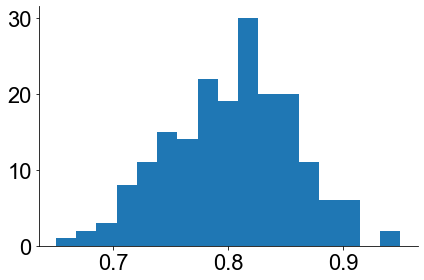

In [125]:
_ = plt.hist(total_acc, bins=17)

In [121]:
training_mode = 'fine_tune'


nt_xent_criterion = NTXentLoss_poly(
            device,
            60, # batch size
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity)  # device, 128, 0.2, True


(total_loss, total_acc, total_auc, total_prc, 
precision, recall, F1, LOSS_P, 
labels_numpy, pred_numpy) = model_finetune(TFC_model,
                                             valid_dl,
                                             nt_xent_criterion,
                                             device,
                                             training_mode,
                                             model_optimizer,
                                             classifier=classifier,
                                             classifier_optimizer=classifier_optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


In [21]:
h_t, z_t, h_f, z_f = TFC_model(x_t, x_f)                 # original data
z_t
rearrange(z_t, '(b c) z -> b z c', c=7).shape  

torch.Size([48, 32, 7])

In [69]:

spatial_filter = nn.Linear(num_channels, 1, bias=False)
# nn.init.eye_(l.weight)

x1 = rearrange(x, 'b c z -> b z c')
x2 = l(x1)
x3 = rearrange(x2, 'b c z -> b z c')

torch.Size([2, 5, 3]) torch.Size([2, 1, 3])


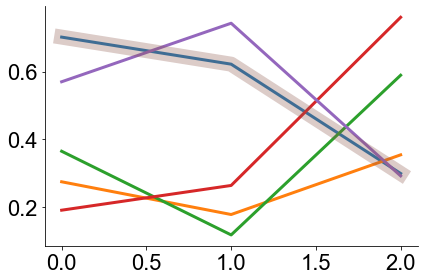

In [78]:
plt.plot(x[0,:,:].T)
plt.plot(x3[0,:,:].detach().numpy().squeeze(), lw=15, alpha=0.3)

In [79]:
fea_concat.shape

torch.Size([7, 64])

In [52]:
x = torch.rand(size=(2, 5, 3))

c = 0
for i in range(2):
    for j in range(5):
        for k in range(3):
            
            x[i, j, k] = c
            c += 1
x

tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.],
         [ 9., 10., 11.],
         [12., 13., 14.]],

        [[15., 16., 17.],
         [18., 19., 20.],
         [21., 22., 23.],
         [24., 25., 26.],
         [27., 28., 29.]]])

In [53]:
rearrange(x, 'b c z -> b z c')

tensor([[[ 0.,  3.,  6.,  9., 12.],
         [ 1.,  4.,  7., 10., 13.],
         [ 2.,  5.,  8., 11., 14.]],

        [[15., 18., 21., 24., 27.],
         [16., 19., 22., 25., 28.],
         [17., 20., 23., 26., 29.]]])

In [54]:
x.permute((0,2,1))

tensor([[[ 0.,  3.,  6.,  9., 12.],
         [ 1.,  4.,  7., 10., 13.],
         [ 2.,  5.,  8., 11., 14.]],

        [[15., 18., 21., 24., 27.],
         [16., 19., 22., 25., 28.],
         [17., 20., 23., 26., 29.]]])